# SGVB with MAP starting conditions

In which we try to speed up stochastic inference by starting with a MAP (Laplace) estimate.

Note, we zero out the covariances between variables, so that the starting covariance is block-diagonal, to make the procedure more stable.

In [1]:
from ptvi import *
import torch
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('precision', 2)
plt.rcParams['figure.figsize'] = [12, 8]

Data generation. **NOTE: these random seeds were cherry-picked**

In [2]:
data_seed, algo_seed = 1234, 1  # change and rerun all

In [3]:
γ0, η0, σ0, ρ0 = 0., 2., 1.5, 0.92
true_params = {'γ': γ0, 'η': η0, 'σ': σ0, 'ρ': ρ0}
torch.manual_seed(data_seed)
model = LocalLevelModel(input_length=100)
y, z = model.simulate(**true_params)

## Approximate inference with MAP starting conditions

Here we can relax the stopping condition a bit, because we know it is already close to a reasonable answer and we can accept a higher probability of an early stop. Depending on the random seed, sometimes it is fast, sometimes not really at all.

In [4]:
torch.manual_seed(algo_seed)
map_fit = map(model, y)
u0, L0 = map_fit.initial_conditions()
stop_heur = NoImprovementStoppingHeuristic(patience=10, ε=.1) # weak
fit = sgvb(model, y, u0=u0, L0=L0, stop_heur=stop_heur)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
MAP inference with L-BGFS: Local level model
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
       0. log joint = -1107.1635
       1. log joint = -353.1488
       2. log joint = -336.8329
       3. log joint = -336.8191
       4. log joint = -336.8190
Convergence criterion met.
       4. log joint = -336.8190
Completed 5 iterations in 0.32s @ 15.62 i/s.
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Structured SGVB Inference for Local level model:
  - Estimating elbo with M=1;
  - Stop on no improvement (skip=1, patience=10, min_steps=100, ε=0.1, α=0.1)
  - Adadelta optimizer with param groups:
    group 0. lr=1.0, rho=0.9, eps=1e-06, weight_decay=0
  - Displayed loss is smoothed with λ=0.1
―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

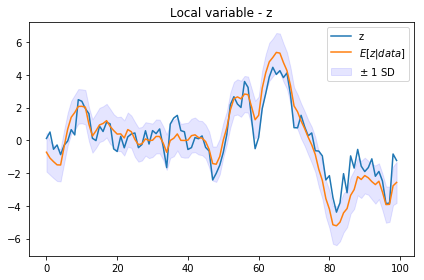

In [5]:
fit.plot_latent(z=z)

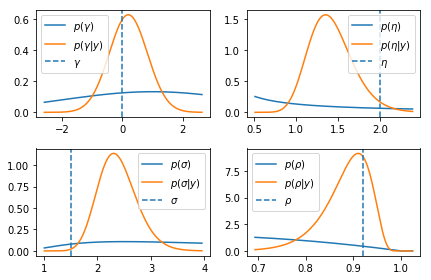

In [6]:
fit.plot_global_marginals(**true_params)

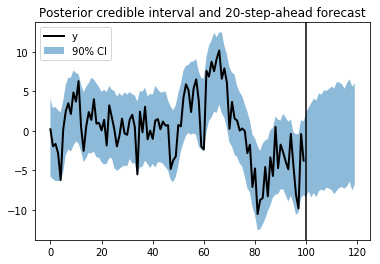

In [7]:
fit.plot_pred_ci(N=500, α=.1, true_y=y, fc_steps=20)

## Comparison: starting at $u=0, L=I$

### With weak stopping rule

Matches the stopping rule we used in the hybrid procedure, above.

In [8]:
torch.manual_seed(algo_seed)
stop_heur = NoImprovementStoppingHeuristic(patience=10, ε=.1)  # weak
fit = sgvb(model, y, stop_heur=stop_heur)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Structured SGVB Inference for Local level model:
  - Estimating elbo with M=1;
  - Stop on no improvement (skip=1, patience=10, min_steps=100, ε=0.1, α=0.1)
  - Adadelta optimizer with param groups:
    group 0. lr=1.0, rho=0.9, eps=1e-06, weight_decay=0
  - Displayed loss is smoothed with λ=0.1
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
       0. smoothed elbo = -971.95
       1. smoothed elbo =-3903.70
       2. smoothed elbo =-4068.88
       4. smoothed elbo =-3723.29
       8. smoothed elbo =-5348.47
      16. smoothed elbo =-10037.90
      32. smoothed elbo =-34016.34
      64. smoothed elbo =-3062.53
     128. smoothed elbo =-7792.43
     256. smoothed elbo =-4052.04
     512. smoothed elbo =-1368.55
    1024. smoothed elbo =-1384.92
    2048. smoothed elbo = -318.20
    4096. smoothed elbo = -293.50
Stopping heuristic criterion satisfied
    7498. smoothed elbo 

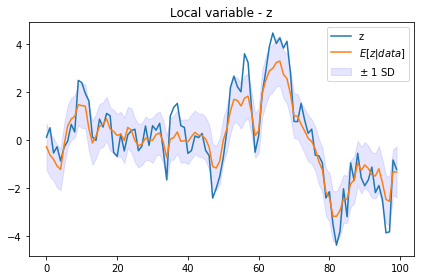

In [9]:
fit.plot_latent(z=z)

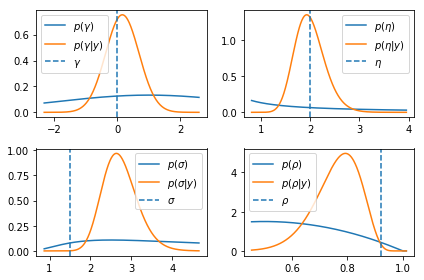

In [10]:
fit.plot_global_marginals(**true_params)

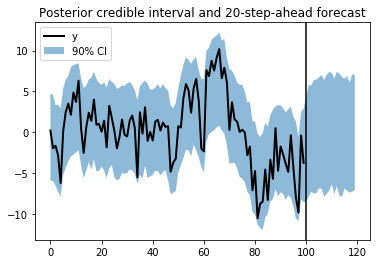

In [11]:
fit.plot_pred_ci(N=500, α=.1, true_y=y, fc_steps=20)

## With strong stopping rule

This is currently the default stopping rule in my codebase

In [12]:
torch.manual_seed(algo_seed)
fit = sgvb(model, y)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Structured SGVB Inference for Local level model:
  - Estimating elbo with M=1;
  - Stop on no improvement (skip=1, patience=10, min_steps=100, ε=0.01, α=0.1)
  - Adadelta optimizer with param groups:
    group 0. lr=1.0, rho=0.9, eps=1e-06, weight_decay=0
  - Displayed loss is smoothed with λ=0.1
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
       0. smoothed elbo = -971.95
       1. smoothed elbo =-3903.70
       2. smoothed elbo =-4068.88
       4. smoothed elbo =-3723.29
       8. smoothed elbo =-5348.47
      16. smoothed elbo =-10037.90
      32. smoothed elbo =-34016.34
      64. smoothed elbo =-3062.53
     128. smoothed elbo =-7792.43
     256. smoothed elbo =-4052.04
     512. smoothed elbo =-1368.55
    1024. smoothed elbo =-1384.92
    2048. smoothed elbo = -318.20
    4096. smoothed elbo = -293.50
Stopping heuristic criterion satisfied
    7498. smoothed elbo

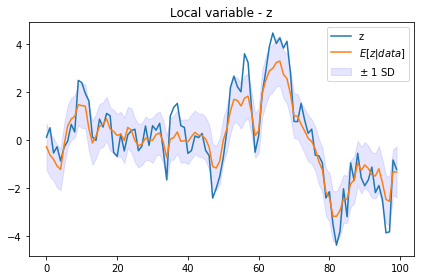

In [13]:
fit.plot_latent(z=z)

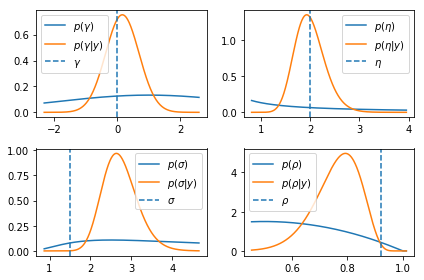

In [14]:
fit.plot_global_marginals(**true_params)

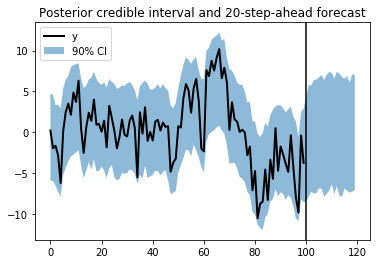

In [15]:
fit.plot_pred_ci(N=500, α=.1, true_y=y, fc_steps=20)